In [513]:
import pennylane as qml
from gate_opt_utils_17 import *
import matplotlib.pyplot as plt
from penny_to_graph_31 import Penny_to_Graph
from graph_utils_1 import *
from quantum_circuit_optimization import *

In [514]:
[ds] = qml.data.load("ketgpt")

KeyboardInterrupt: 

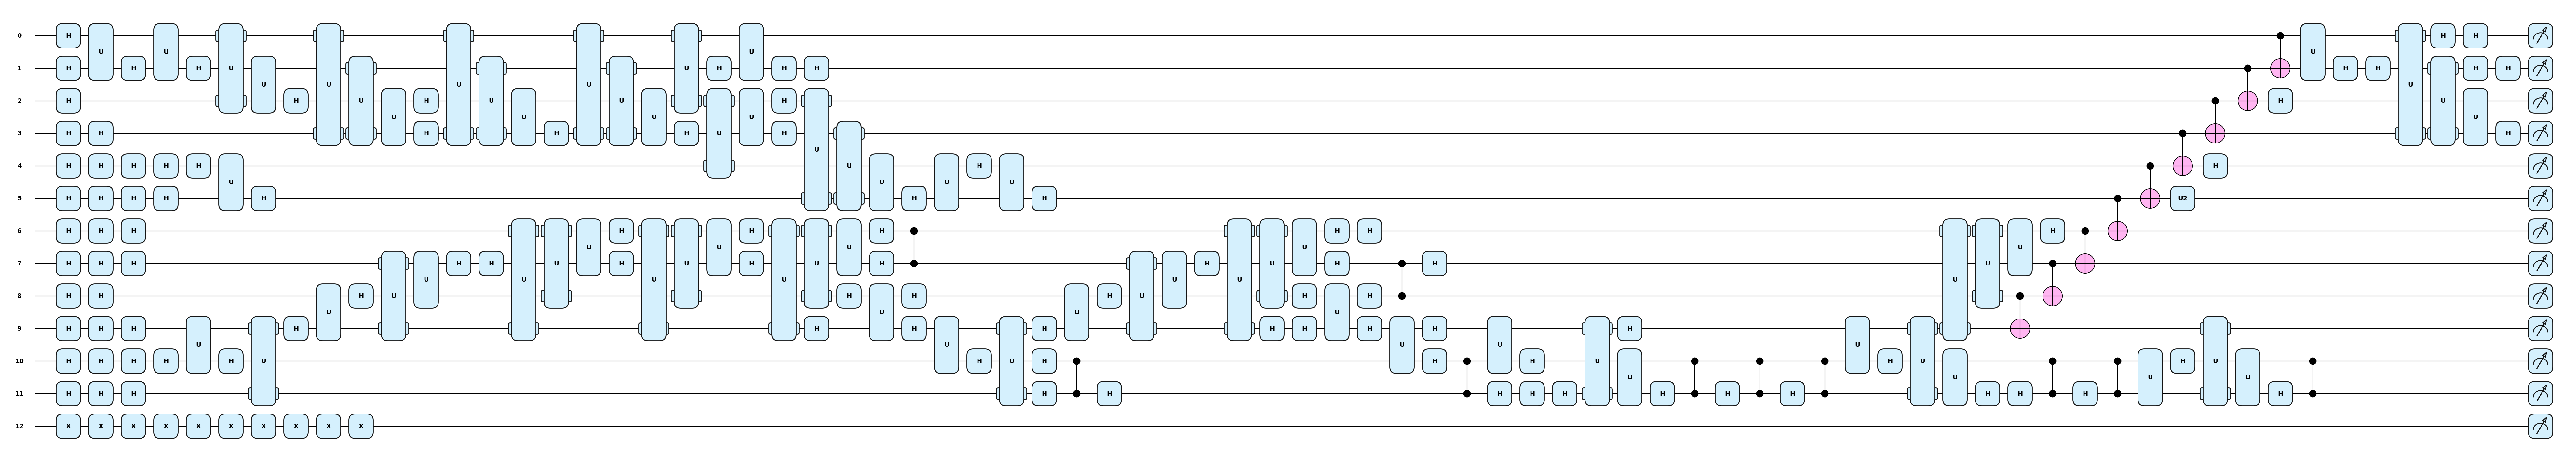

               0
num_qubit     13
num_gate     199
num_1q_gate  116
num_2q_gate   19
unitary       64
depth         66
None


In [ ]:
seed = 0

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

print(summary_penny(circuit))

               0
num_qubit     12
num_gate     145
num_1q_gate   62
num_2q_gate   19
unitary       64
depth         67
None


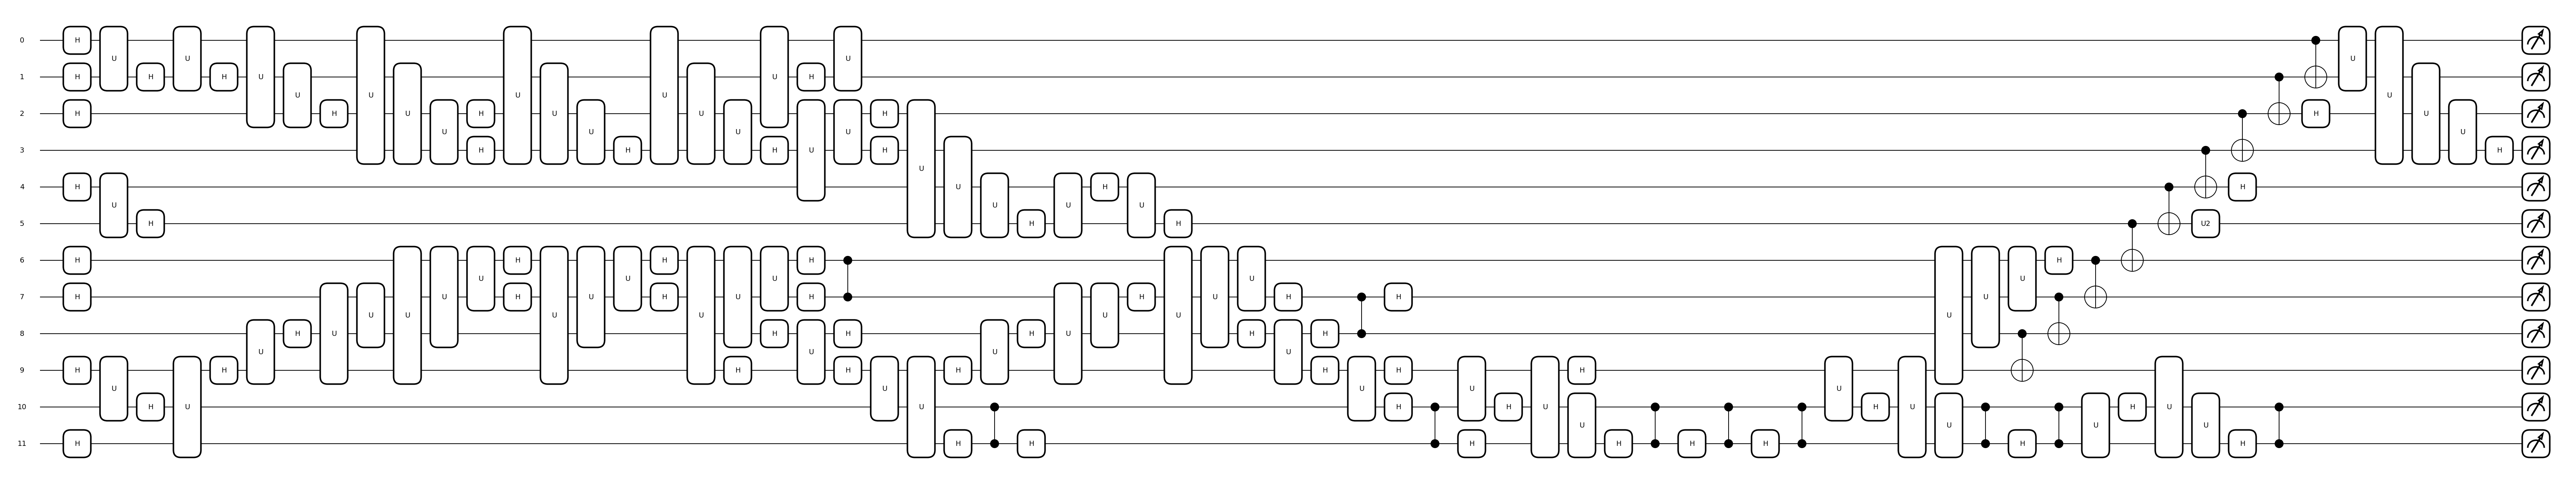

In [ ]:
qnode = optimization_lev_1(ds, circuit, seed=0)

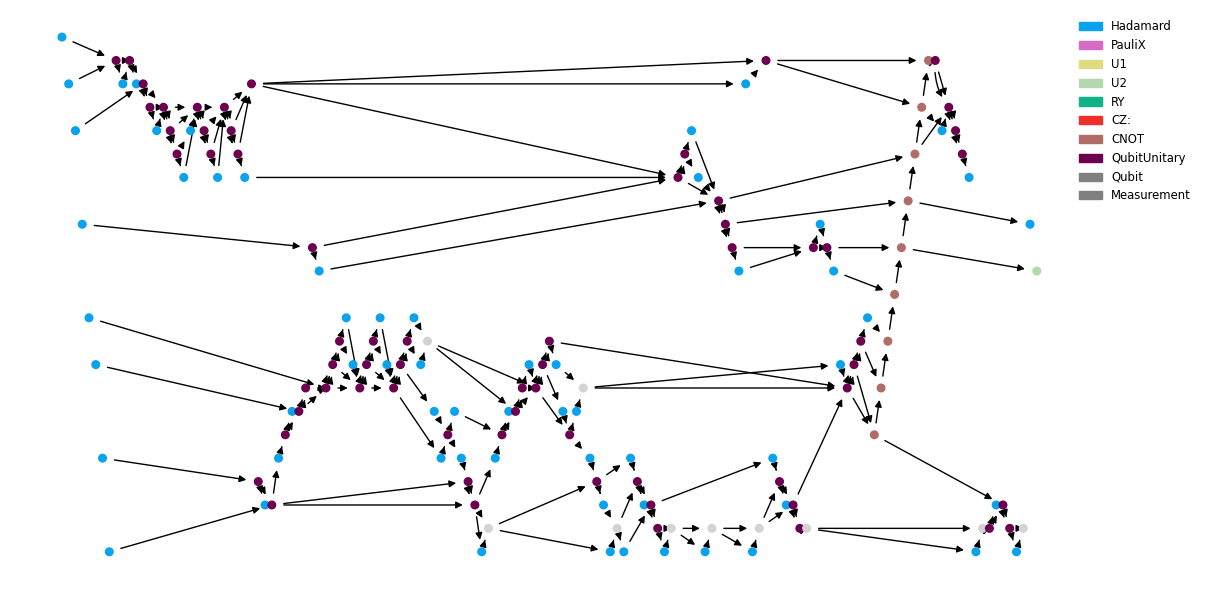

In [ ]:
pg = Penny_to_Graph(qnode)
pg.show_graph(pg.G)

In [ ]:
G, communities = graph_alg_level_1(pg.G, barriers=['QubitUnitary'])
effective_u_dic = subcircuit_syntehsis(G, ds, communities, seed)

In [ ]:
G.nodes()['Hadamard_0']

{'type': 'gate',
 'label': 'Hadamard',
 'params': [],
 'wires': [0],
 'num_q': 1,
 'community': 0}

In [ ]:
def between_nodes(G_directed, source, target):
    G = nx.DiGraph(G_directed)
    paths = list(nx.all_simple_paths(G, source=source, target=target))
    flat_nodes = set()
    for path in paths:
        flat_nodes.update(path)
    flat_nodes.remove(source)
    flat_nodes.remove(target)
    return flat_nodes

between_nodes(G, 'QubitUnitary_113', 'CNOT_124')

In [550]:
def get_wire(G, node):
    return G.nodes[node]['wires']

In [551]:
subgraphs = []
G_directed = pg.G
G_undirected = G_directed.to_undirected()
gate_2q = [n for n, attr in G_undirected.nodes(data=True) if attr.get('num_q') == 2]
# gate_2q = ['CNOT_124']

for center in gate_2q:
    reference_wires = set(get_wire(G_undirected, center))
    visited = set()
    stack = [center]
    valid_nodes = set()

    while stack:
        current = stack.pop()
        if current in visited:
            continue
        visited.add(current)

        current_wires = set(get_wire(G_undirected, current))
        if not current_wires.issubset(reference_wires):
            continue

        valid_nodes.add(current)

        # Predecessors
        for pred in G_directed.predecessors(current):
            if pred in visited:
                continue

            pred_wires = set(get_wire(G_undirected, pred))
            if not pred_wires.issubset(reference_wires):
                continue

            if G_directed.nodes[pred].get('num_q') == 2:
                succ = between_nodes(G_directed, pred, current)
                if len(succ) == 0:
                    continue
                succ_wires = []
                for s in succ:
                    succ_wires.extend(get_wire(G_undirected, s))
                if not set(succ_wires).issubset(reference_wires):
                    continue

            stack.append(pred)

        # Successors
        for succ in G_directed.successors(current):
            if succ in visited:
                continue

            succ_wires = set(get_wire(G_undirected, succ))
            if not succ_wires.issubset(reference_wires):
                continue

            if G_directed.nodes[succ].get('num_q') == 2:
                preds = between_nodes(G_directed, current, succ)
                if len(preds) == 0:
                    continue
                preds_wires = []
                for p in preds:
                    preds_wires.extend(get_wire(G_undirected, p))
                if not set(preds_wires).issubset(reference_wires):
                    continue

            stack.append(succ)

    if len(valid_nodes) > 1:
        subG = G_undirected.subgraph(valid_nodes).copy()
        subgraphs.append({'center': center, 'wires': list(reference_wires), 'subG': subG})

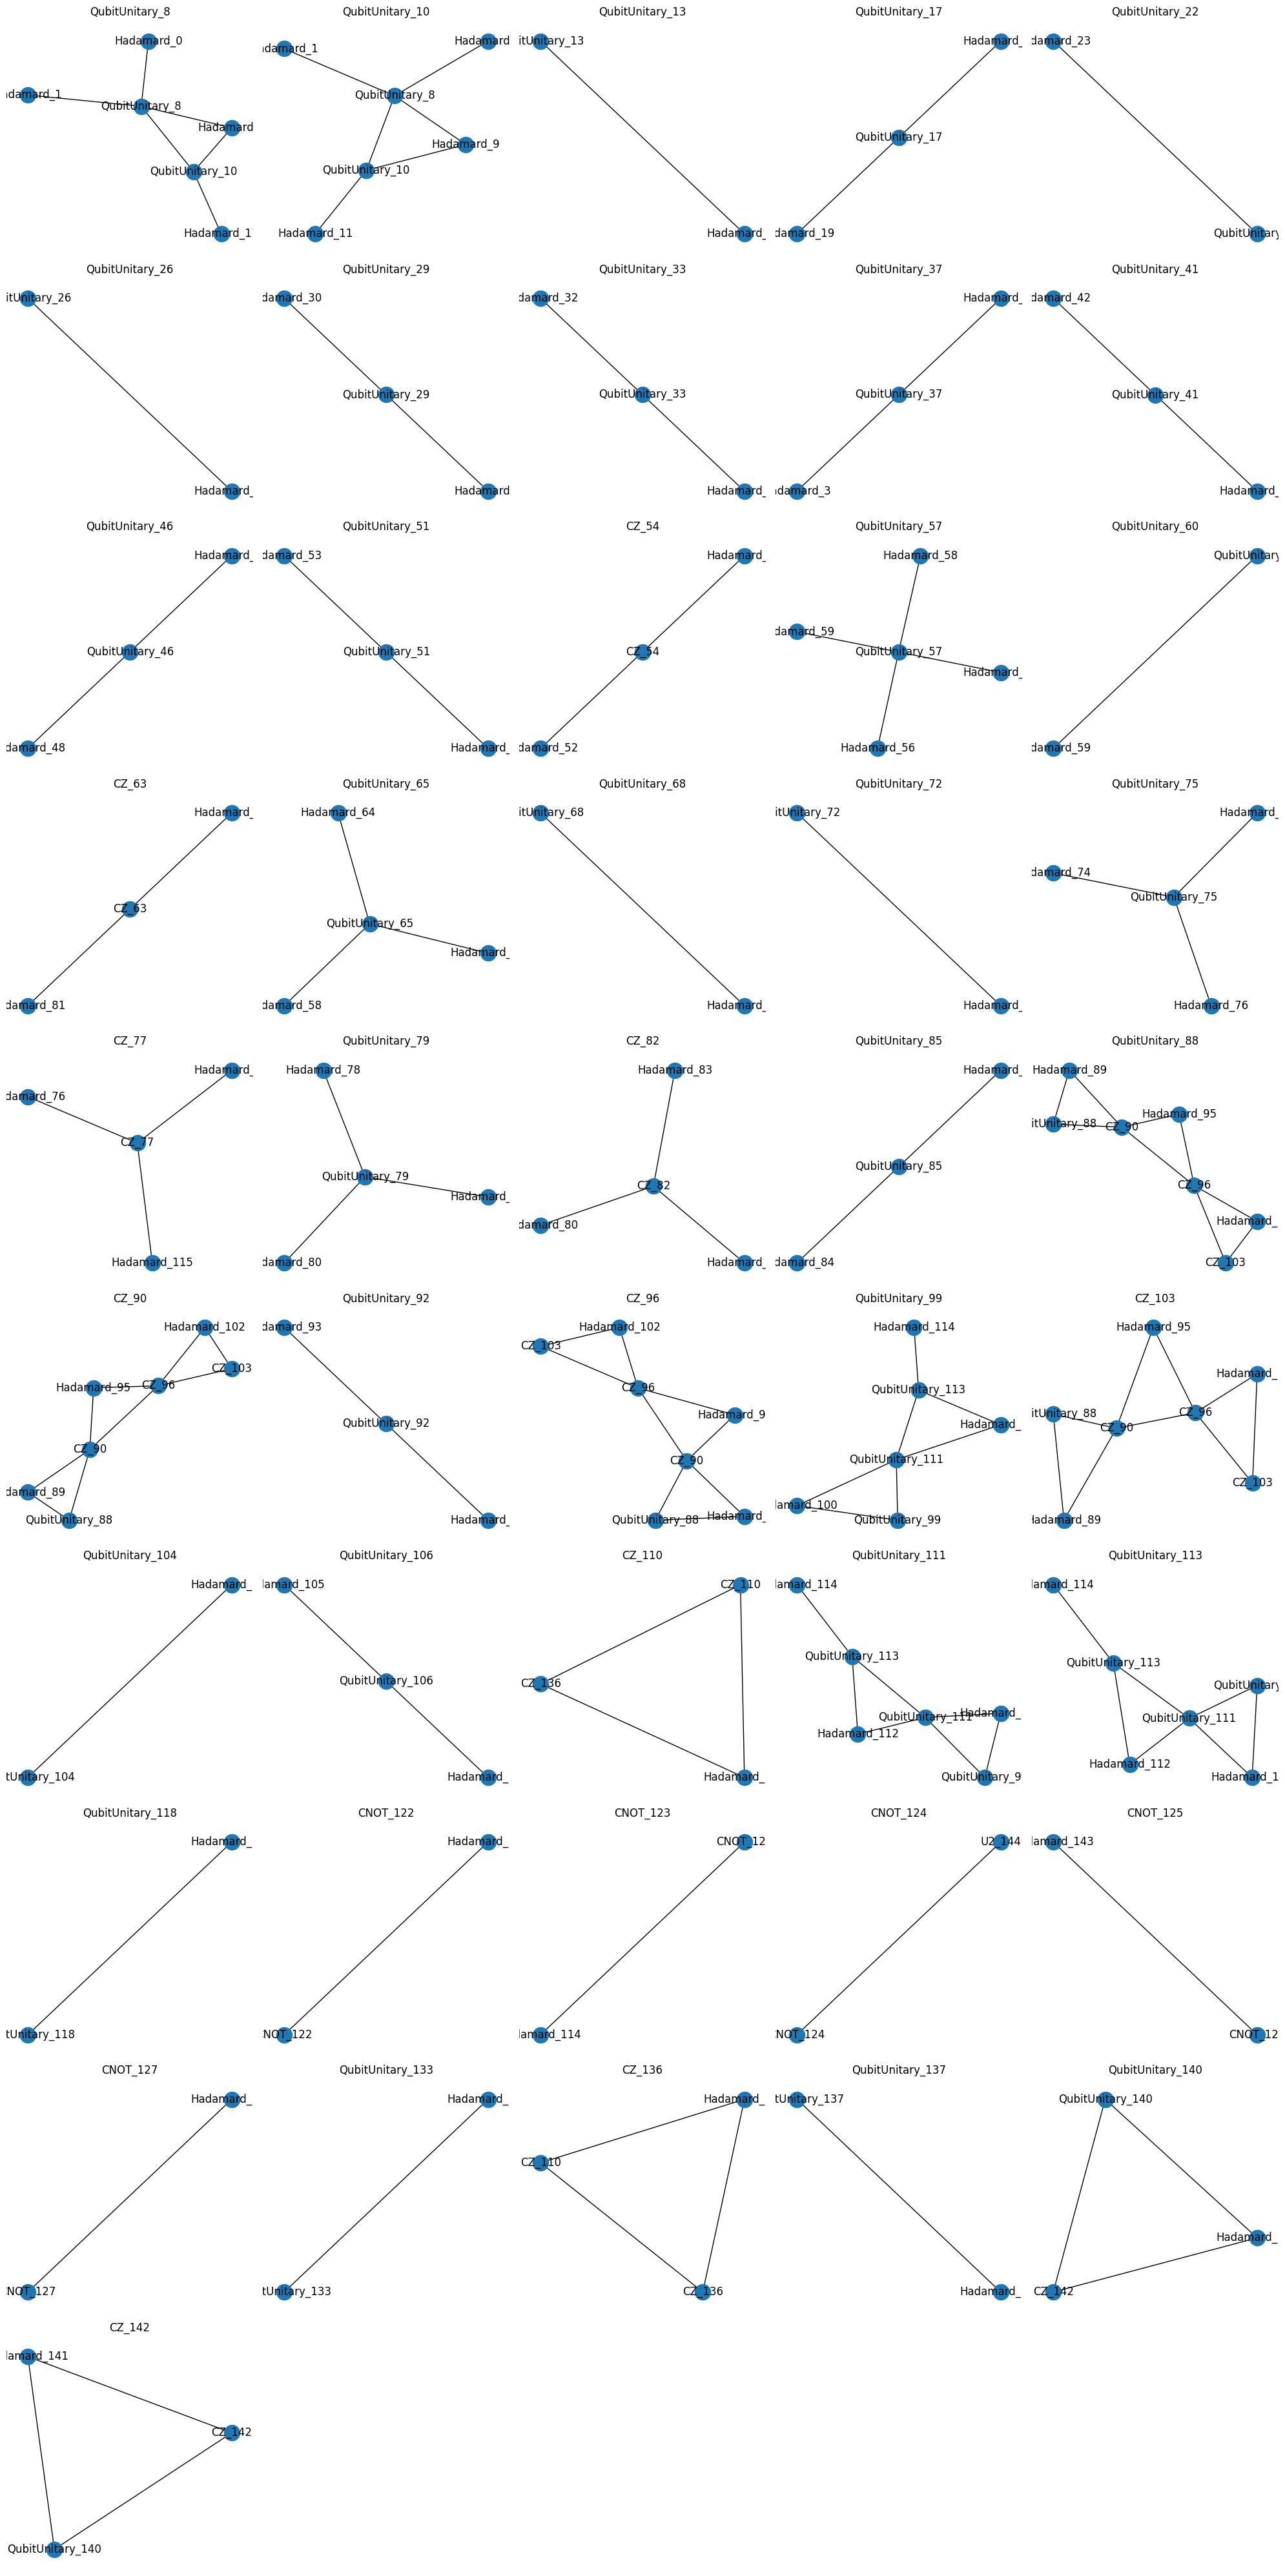

In [552]:
draw_subgraphs(subgraphs)

145 48


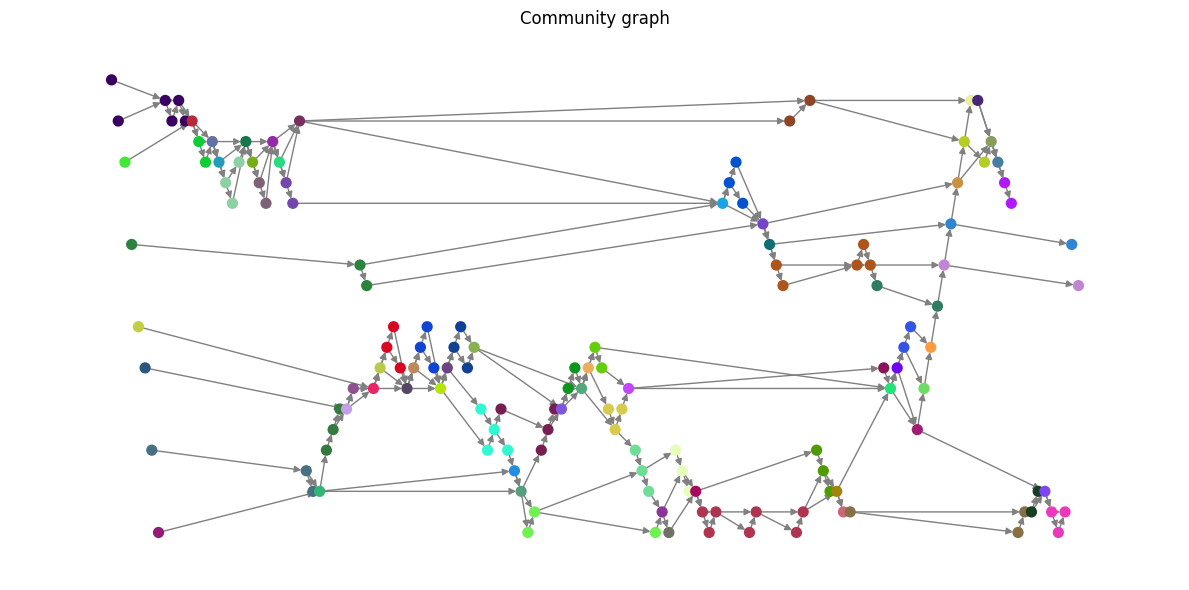

In [553]:
# new_subgraph = subgraph_trimming(subgraphs)
unique_subgraphs = get_unique_subgraphs(subgraphs)
communities = []
for elem in unique_subgraphs:
    communities.append(set(elem['nodes']))

barriers = [n for n in list(G.nodes()) if n not in set().union(*communities)]
print(len(G.nodes), len(barriers))
G, communities = community_sort(G, communities, barriers)

community_graph(G, pg.pos, communities)

In [539]:
def wire_range_2(gate_dic):
    wire__list = [elem['wires'] for elem in gate_dic]
    flat = [item for sublist in wire__list for item in sublist]
    return [min(flat), max(flat)]

def info_to_qnode_matrix(circuit_info):
    with qml.tape.QuantumTape() as tape:
        for gate in circuit_info:
            name = gate['name']
            wires = gate['wires']
            params = gate['params']
            if name == 'Hadamard':
                qml.Hadamard(wires=wires[0])
            elif name == 'PauliX':
                qml.PauliX(wires=wires[0])
            elif name == 'U2':
                qml.U2(params[0], params[1], wires=wires[0])
            elif name == 'CNOT':
                qml.CNOT(wires=wires)            
            elif name == 'CZ':
                qml.CZ(wires=wires)
            elif name == 'QubitUnitary':
                matrix = np.array(params[0])
                qml.QubitUnitary(matrix, wires=wires)
            else:
                raise ValueError(f"Unsupported gate: {name}")
    wires = wire_range_2(circuit_info)
    return qml.matrix(tape, wire_order=wires), wires

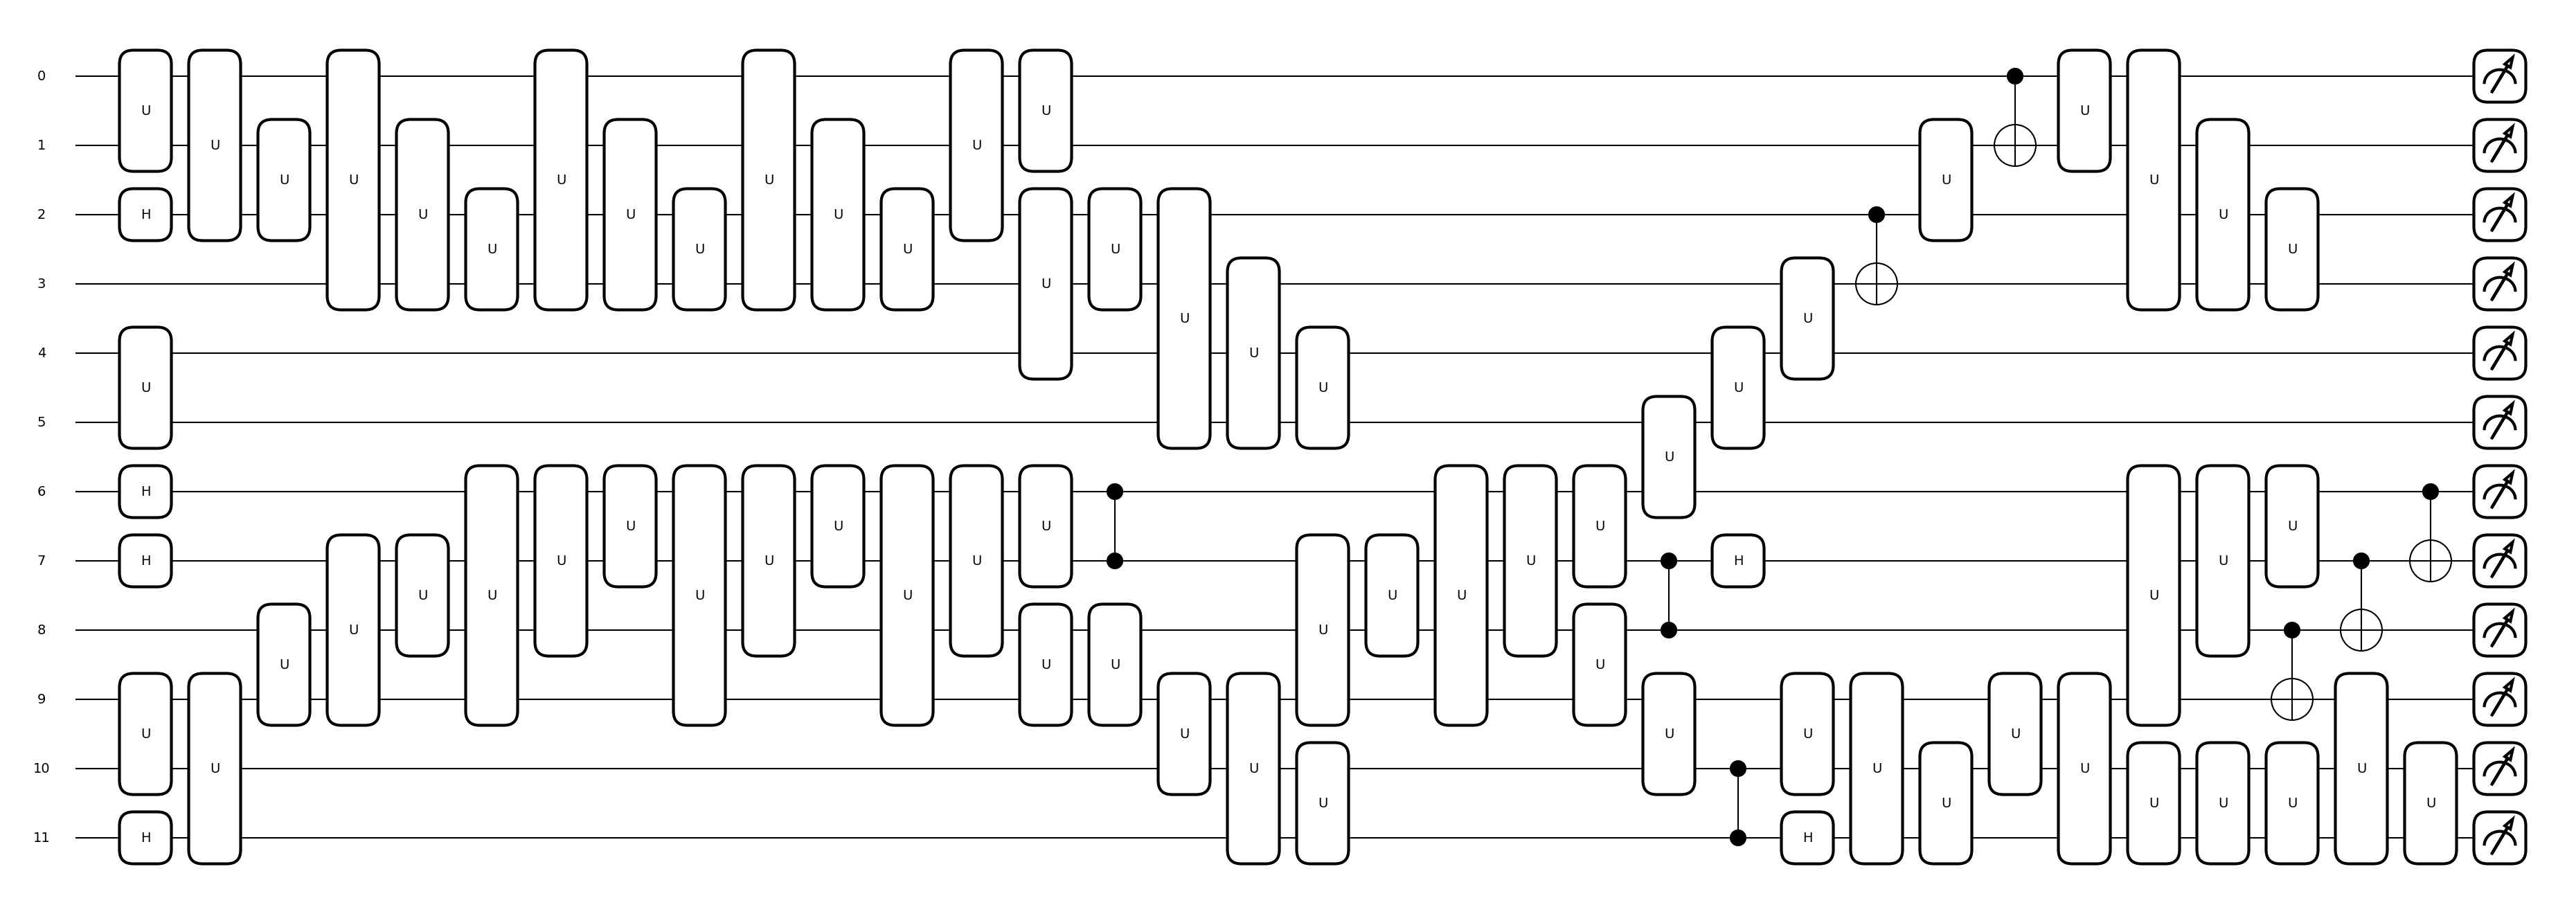

In [ ]:
circuit_info = extract_info_from_qnode(qnode)

num_community = len(communities)
synthesis_idx = []
subcircuit_idx_arr = []
for i in range(num_community):
    temp_gate = [n for n in G.nodes if G.nodes[n].get('community') == i]
    temp_gate = [item for item in temp_gate if item]
    if temp_gate == []:
        continue
    temp_com_label = [int(g.split('_')[1]) for g in temp_gate]
    subcircuit_idx_arr.append(temp_com_label)
    synthesis_idx.append(min(temp_com_label))

# index to circuit_info
community_circuit_info = []
synthesis_idx = []
for idx_list in subcircuit_idx_arr:
    target = [circuit_info[j] for j in idx_list]
    if target == []:
        continue
    community_circuit_info.append(target)
    synthesis_idx.append(min(idx_list))

for idx, ci in enumerate(community_circuit_info):
    if len(ci) > 1:
        matrix, wries = info_to_qnode_matrix(ci)
        community_circuit_info[idx] =  [{'name': 'QubitUnitary', 'wires': wries, 'params':[matrix]}] # replaced

community_circuit_info = np.array(community_circuit_info).flatten()

qnode_syn = info_to_qnode(community_circuit_info)
qml.draw_mpl(qnode_syn)()
plt.show()

In [16]:
# we need to conduct backtracking
subgraphs = []
gate_2q = [n for n, attr in pg.G.nodes(data=True) if attr['num_q'] == 2]

for center in gate_2q:
    radius = 0
    wires = pg.G.nodes[center]['wires']
    prev_subG = None

    while True:
        bool_list = []
        subG = nx.ego_graph(pg.G.to_undirected(), center, radius=radius)
        for node, attr in subG.nodes(data=True):
            bool_list.append(set(attr['wires']).issubset(wires))        

        if bool_list.count(False) > 1:
            if prev_subG is not None:
                subgraphs.append({'center': center, 'wires':wires, 'subG': prev_subG})
            break
        else:
            prev_subG = subG 
            radius += 1

In [17]:
def draw_subgraphs(subgraphs):
    num_subgraphs = len(subgraphs)
    cols = 5
    rows = (num_subgraphs + cols - 1) // cols 

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  
    axes = axes.flatten()  

    for i in range(num_subgraphs):
        nx.draw(subgraphs[i]['subG'], ax=axes[i], with_labels=True)
        axes[i].set_title(subgraphs[i]['center'])

    # Hide any unused axes
    for j in range(num_subgraphs, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

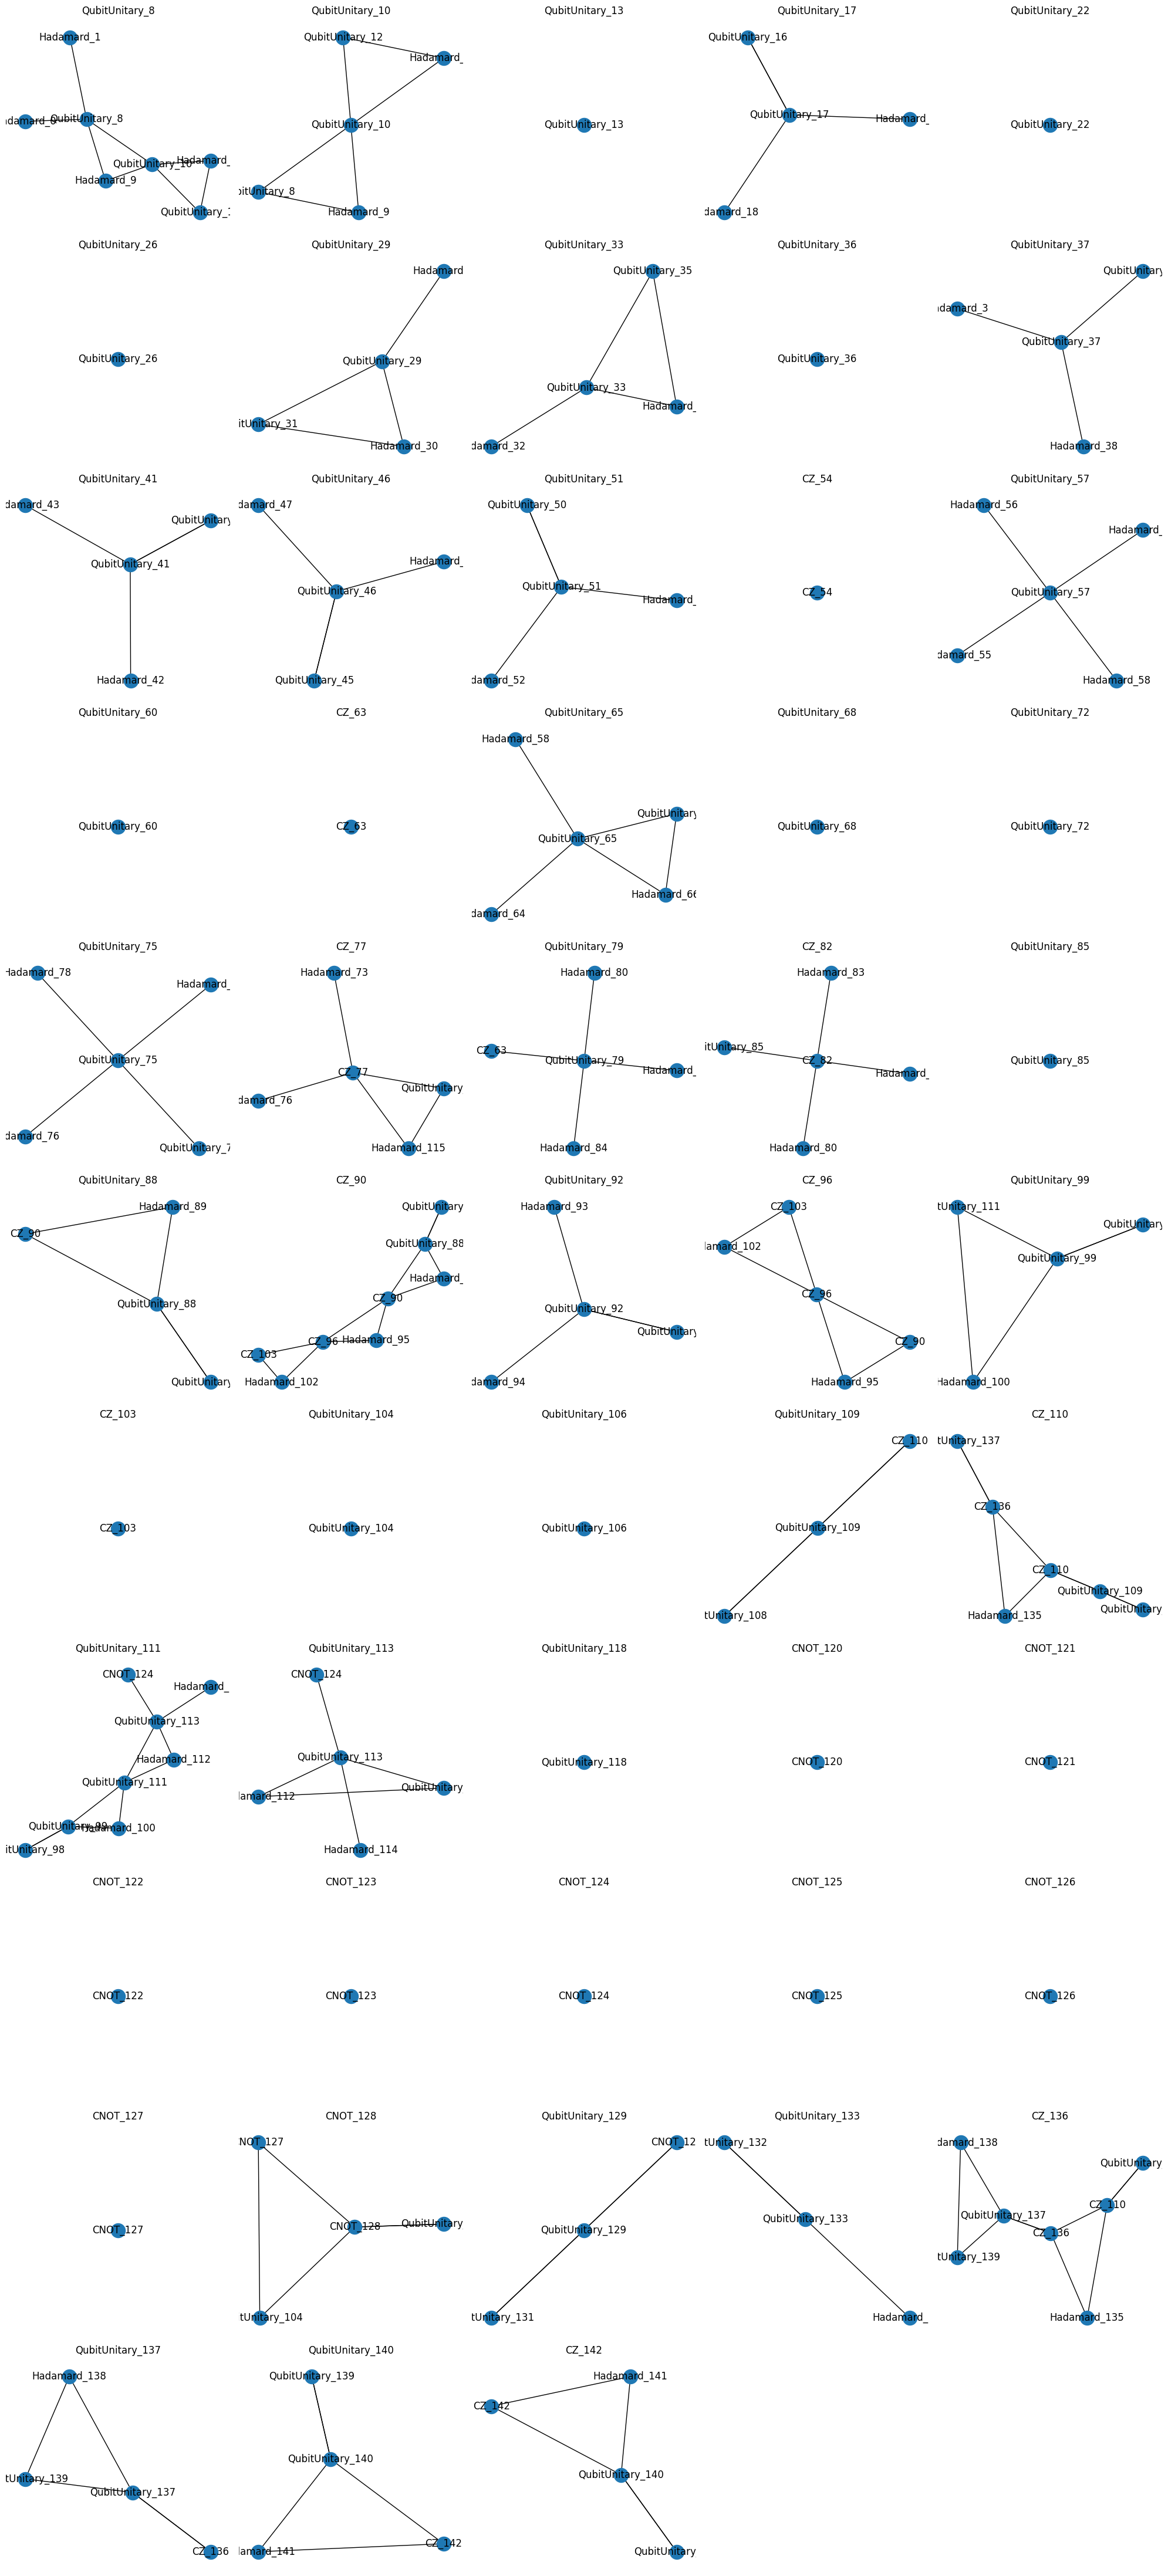

In [18]:
draw_subgraphs(subgraphs)

In [12]:
# change the subgraphs
new_subgraph = subgraphs.copy()
# drop standalone nodes
effective_idx = []
for idx, elem in enumerate(subgraphs):
    if len(elem['subG'].nodes()) == 1:
        continue
    else:
        effective_idx.append(idx)

new_subgraph = [new_subgraph[i] for i in effective_idx]

for idx, elem in enumerate(new_subgraph):
    reference_wires = elem['wires']
    subG = elem['subG'] 
    # remove nodes outside the ference wires
    nodes_to_remove = [
        node for node, attr in subG.nodes(data=True)
        if not set(attr.get('wires', [])).issubset(reference_wires)
    ]
    subG.remove_nodes_from(nodes_to_remove)
    new_subgraph[idx]['subG'] = subG

In [13]:
# concisely,
new_subgraph = [elem for elem in subgraphs if len(elem['subG'].nodes()) > 1]
for elem in new_subgraph:
    reference_wires = set(elem['wires'])
    subG = elem['subG']
    nodes_to_remove = [node for node, attr in subG.nodes(data=True) if not set(attr.get('wires', [])).issubset(reference_wires)]
    subG.remove_nodes_from(nodes_to_remove)

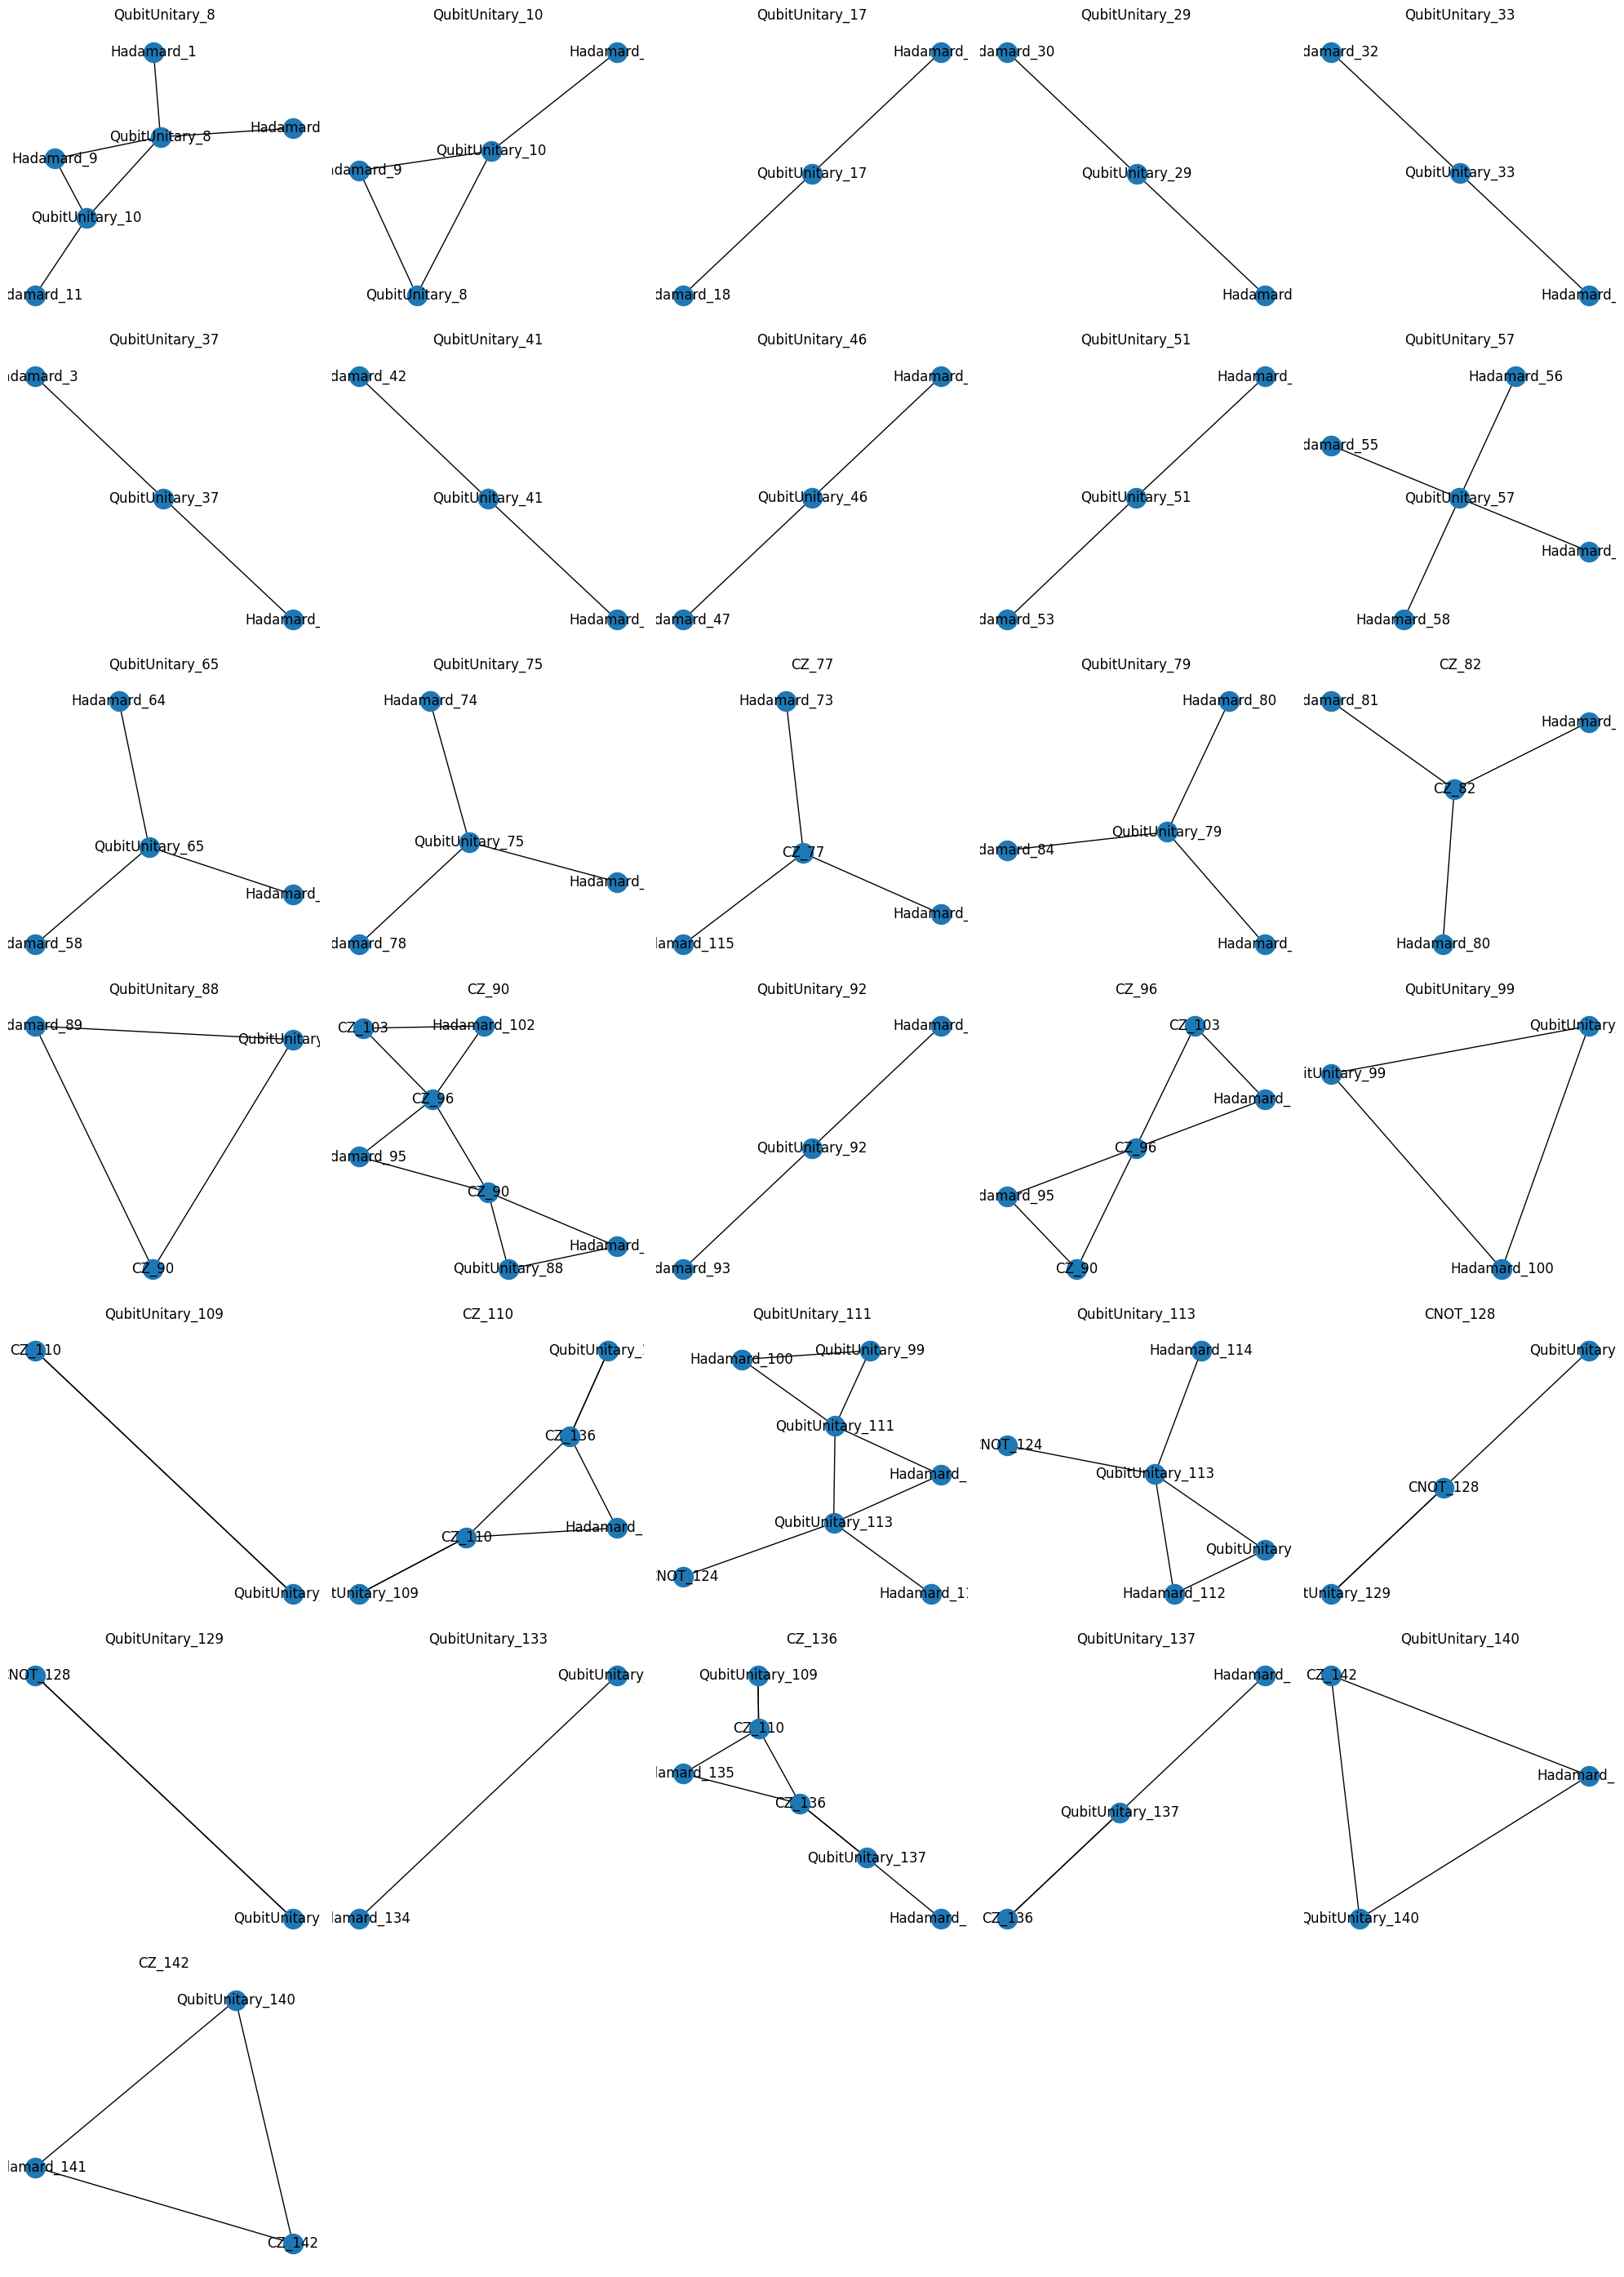

In [14]:
draw_subgraphs(new_subgraph)

In [15]:
unique_subgraphs = []

for candidate in new_subgraph:
    subG = candidate['subG']
    is_duplicate = any(nx.is_isomorphic(subG, existing['subG']) for existing in unique_subgraphs)
    
    if not is_duplicate:
        unique_subgraphs.append(candidate)

print(len(new_subgraph))
print(len(unique_subgraphs))

31
15


In [16]:
new_subgraph[0]

{'center': 'QubitUnitary_8',
 'wires': [0, 1],
 'subG': <networkx.classes.multigraph.MultiGraph at 0x15ee01b7940>}

In [17]:
unique_subgraphs = [new_subgraph[0]]

for i in range(1, len(new_subgraph)):
    prev_nodes = set(new_subgraph[i - 1]['subG'].nodes())
    curr_nodes = set(new_subgraph[i]['subG'].nodes())

    # If they share nodes, keep the one with more nodes
    if prev_nodes & curr_nodes:
        if len(curr_nodes) > len(prev_nodes):
            unique_subgraphs[-1] = new_subgraph[i] 
    else:
        unique_subgraphs.append(new_subgraph[i])

print(len(new_subgraph))
print(len(unique_subgraphs))

31
21


In [18]:
# add node list
for idx, elem in enumerate(unique_subgraphs):
    unique_subgraphs[idx]['nodes'] = list(elem['subG'].nodes())

In [19]:
communities = []
for elem in unique_subgraphs:
    communities.append(set(elem['nodes']))
communities[:5]

[{'Hadamard_0',
  'Hadamard_1',
  'Hadamard_11',
  'Hadamard_9',
  'QubitUnitary_10',
  'QubitUnitary_8'},
 {'Hadamard_18', 'Hadamard_19', 'QubitUnitary_17'},
 {'Hadamard_30', 'Hadamard_6', 'QubitUnitary_29'},
 {'Hadamard_32', 'Hadamard_34', 'QubitUnitary_33'},
 {'Hadamard_3', 'Hadamard_38', 'QubitUnitary_37'}]

In [20]:
G = pg.G
barriers = [n for n in list(G.nodes()) if n not in set().union(*communities)] # those do not belong to any communities
print(len(G.nodes()), len(barriers))

145 75


In [21]:
# barriers as singleton communities
for barrier in barriers:
    communities.append({barrier})

# rearange community indices 
node_to_original_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_original_community[node] = i

##### internal function
def extract_index(name):
    match = re.search(r'_(\d+)$', name)
    return int(match.group(1)) if match else None
#####

sorted_nodes = sorted(G.nodes(), key=extract_index)

original_to_new_index = {}
new_index = 0
node_to_reindexed_community = {}

for node in sorted_nodes:
    original = node_to_original_community[node]
    if original not in original_to_new_index:
        original_to_new_index[original] = new_index
        new_index += 1
    node_to_reindexed_community[node] = original_to_new_index[original]

# community index as a node attribute
for node in G.nodes:
    G.nodes[node]['community'] = node_to_reindexed_community[node]

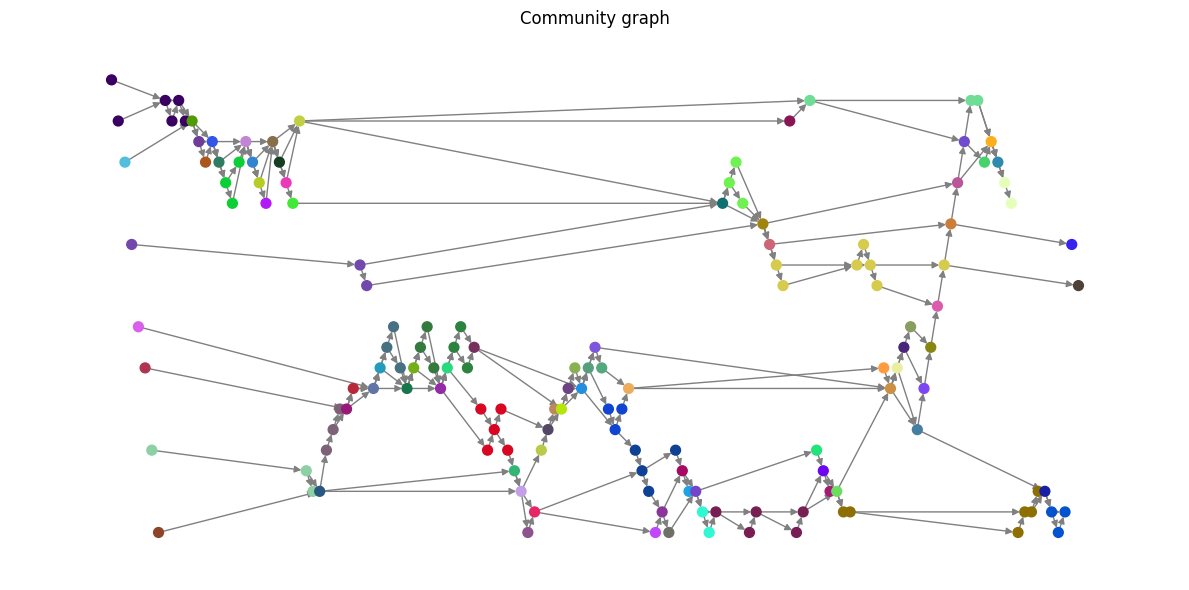

In [22]:
import random
def color_generator(n):
    random.seed(42)
    colors = []
    for _ in range(n):
        hex_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.append(hex_color)
    return colors

palette = color_generator(len(communities))

# Step 2: Assign colors to communities
node_color_map = {}
for i, community in enumerate(communities):
    color = palette[i % len(palette)]
    for node in community:
        node_color_map[node] = color

# Step 3: Build node_colors list
pos = pg.pos
node_colors = [node_color_map.get(node, '#999999') for node in G.nodes]

# Step 4: Draw the graph
fig, ax = plt.subplots(figsize=(12, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=50, font_size=8, edge_color='gray', ax=ax)
plt.title('Community graph')
plt.tight_layout()
plt.show()

=== with functions 

145 75


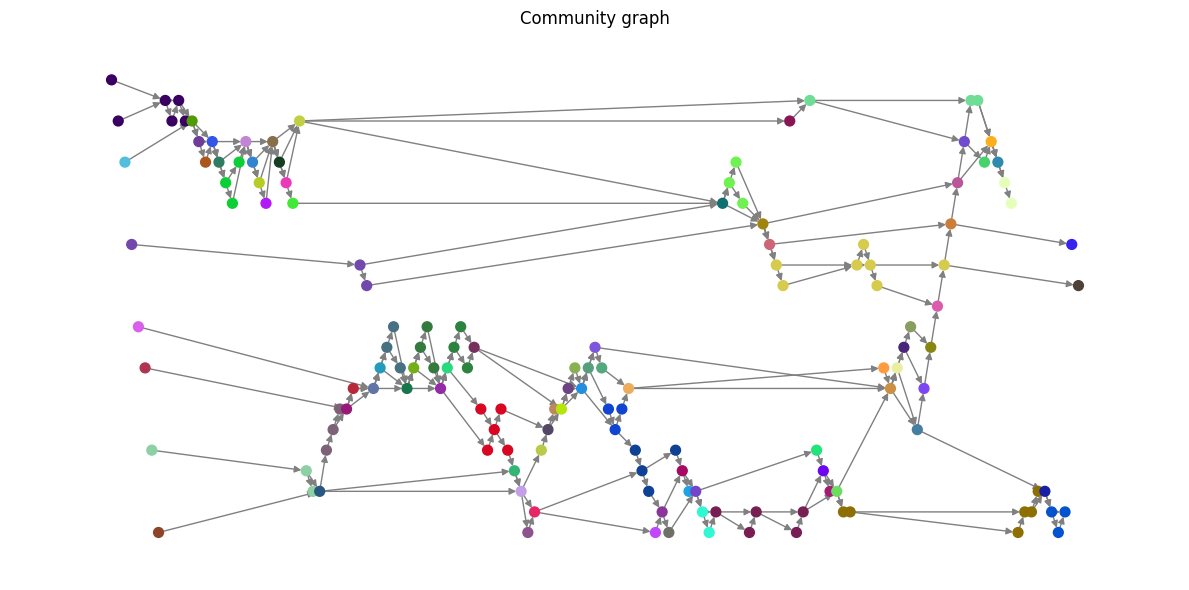

In [24]:
# with methods
G = pg.G
G, communities = graph_alg_level_3(G)
community_graph(G, pg.pos, communities)

In [25]:
communities

[{'Hadamard_0',
  'Hadamard_1',
  'Hadamard_11',
  'Hadamard_9',
  'QubitUnitary_10',
  'QubitUnitary_8'},
 {'Hadamard_18', 'Hadamard_19', 'QubitUnitary_17'},
 {'Hadamard_30', 'Hadamard_6', 'QubitUnitary_29'},
 {'Hadamard_32', 'Hadamard_34', 'QubitUnitary_33'},
 {'Hadamard_3', 'Hadamard_38', 'QubitUnitary_37'},
 {'Hadamard_42', 'Hadamard_43', 'QubitUnitary_41'},
 {'Hadamard_47', 'Hadamard_48', 'QubitUnitary_46'},
 {'Hadamard_52', 'Hadamard_53', 'QubitUnitary_51'},
 {'Hadamard_55',
  'Hadamard_56',
  'Hadamard_58',
  'Hadamard_59',
  'QubitUnitary_57'},
 {'Hadamard_74', 'Hadamard_76', 'Hadamard_78', 'QubitUnitary_75'},
 {'Hadamard_78', 'Hadamard_80', 'Hadamard_84', 'QubitUnitary_79'},
 {'CZ_103',
  'CZ_90',
  'CZ_96',
  'Hadamard_102',
  'Hadamard_89',
  'Hadamard_95',
  'QubitUnitary_88'},
 {'Hadamard_93', 'Hadamard_94', 'QubitUnitary_92'},
 {'CZ_103', 'CZ_90', 'CZ_96', 'Hadamard_102', 'Hadamard_95'},
 {'Hadamard_100', 'QubitUnitary_111', 'QubitUnitary_99'},
 {'CZ_110', 'CZ_136', 'Hada

In [26]:
num_community = len(communities)

subcircuit_idx_arr = []
for i in range(num_community):
    temp_gate = [n for n in G.nodes if G.nodes[n].get('community') == i]
    temp_gate = [item for item in temp_gate if item]
    temp_com_label = [int(g.split('_')[1]) for g in temp_gate]
    subcircuit_idx_arr.append(temp_com_label)

subcircuit_idx_arr

[[0, 1, 8, 9, 10, 11],
 [2],
 [3, 37, 38],
 [4],
 [5],
 [6, 29, 30],
 [7],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17, 18, 19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28],
 [31],
 [32, 33, 34],
 [35],
 [36],
 [39],
 [40],
 [41, 42, 43],
 [44],
 [45],
 [46, 47, 48],
 [49],
 [50],
 [51, 52, 53],
 [54],
 [55, 56, 57, 58, 59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [65],
 [66],
 [67],
 [68],
 [69],
 [70],
 [71],
 [72],
 [73],
 [74, 75, 76],
 [77],
 [78, 79, 80, 84],
 [81],
 [82],
 [83],
 [85],
 [86],
 [87],
 [88, 89],
 [90, 95, 96, 102, 103],
 [91],
 [92, 93, 94],
 [97],
 [98],
 [99, 100, 111, 112, 113, 114, 124],
 [101],
 [104, 128, 129],
 [105],
 [106],
 [107],
 [108],
 [109, 110, 135, 136, 137, 138],
 [115],
 [116],
 [117],
 [118],
 [119],
 [120],
 [121],
 [122],
 [123],
 [125],
 [126],
 [127],
 [130],
 [131],
 [132],
 [133, 134],
 [139],
 [140, 141, 142],
 [143],
 [144],
 [],
 []]

In [27]:
# gate list
subcircuit_gate_arr = []
for i in range(len(subcircuit_idx_arr)):
    temp = [ds.circuits[seed][j] for j in subcircuit_idx_arr[i]]
    if len(temp) > 0:
        subcircuit_gate_arr.append(temp)
    else:
        continue

subcircuit_gate_arr

[[H(0), H(1), H(8), H(9), H(10), H(9)],
 [H(2)],
 [H(3),
  QubitUnitary(array([[1.        +0.j        , 0.        +0.j        ,
          0.        +0.j        , 0.        +0.j        ],
         [0.        +0.j        , 1.        +0.j        ,
          0.        +0.j        , 0.        +0.j        ],
         [0.        +0.j        , 0.        +0.j        ,
          1.        +0.j        , 0.        +0.j        ],
         [0.        +0.j        , 0.        +0.j        ,
          0.        +0.j        , 0.92387953-0.38268343j]]), wires=[3, 0]),
  QubitUnitary(array([[1.        +0.j        , 0.        +0.j        ,
          0.        +0.j        , 0.        +0.j        ],
         [0.        +0.j        , 1.        +0.j        ,
          0.        +0.j        , 0.        +0.j        ],
         [0.        +0.j        , 0.        +0.j        ,
          1.        +0.j        , 0.        +0.j        ],
         [0.        +0.j        , 0.        +0.j        ,
          0.        +0.

In [44]:
test = subcircuit_gate_arr[2]
[type(i)==qml.ops.qubit.matrix_ops.QubitUnitary for i in test]

[False, True, True]

In [45]:
def is_penny_unitary(g):
    return type(g)==qml.ops.qubit.matrix_ops.QubitUnitary

In [46]:
[is_penny_unitary(i) for i in test]

[False, True, True]

In [38]:
u_arr = []
wire_arr = []
for i in range(len(subcircuit_gate_arr)):
    if len(subcircuit_gate_arr[i]) > 1: # cal effective u
        u_temp, w_temp = calculate_effective_u(subcircuit_gate_arr[i])
    else: # leave it as it is
        u_temp
    u_arr.append(u_temp)
    wire_arr.append(w_temp)

effective_u_dic = {}
effective_u_dic['u'] = u_arr
effective_u_dic['wires'] = wire_arr

In [11]:
effective_u_dic

{'u': [array([[ 0.25+0.j,  0.25+0.j,  0.  +0.j, ...,  0.  +0.j,  0.  +0.j,
           0.  +0.j],
         [ 0.25+0.j, -0.25+0.j,  0.  +0.j, ...,  0.  +0.j,  0.  +0.j,
           0.  +0.j],
         [ 0.  +0.j,  0.  +0.j,  0.25+0.j, ...,  0.  +0.j,  0.  +0.j,
           0.  +0.j],
         ...,
         [ 0.  +0.j,  0.  +0.j,  0.  +0.j, ...,  0.25+0.j,  0.  +0.j,
           0.  +0.j],
         [ 0.  +0.j,  0.  +0.j,  0.  +0.j, ...,  0.  +0.j, -0.25+0.j,
          -0.25+0.j],
         [ 0.  +0.j,  0.  +0.j,  0.  +0.j, ...,  0.  +0.j, -0.25+0.j,
           0.25+0.j]]),
  array([[ 0.70710678+0.j,  0.70710678+0.j],
         [ 0.70710678+0.j, -0.70710678+0.j]]),
  array([[ 0.70710678+0.j        ,  0.70710678+0.j        ,
           0.        +0.j        ,  0.        +0.j        ,
           0.        +0.j        ,  0.        +0.j        ,
           0.        +0.j        ,  0.        +0.j        ,
           0.        +0.j        ,  0.        +0.j        ,
           0.        +0.j        , 

In [12]:
def is_unitary(matrix, tol=1e-10):
    matrix = np.array(matrix)
    if matrix.shape[0] != matrix.shape[1]:
        return False
    identity = np.eye(matrix.shape[0])
    return np.allclose(matrix.conj().T @ matrix, identity, atol=tol)

In [ ]:
# Build circuit
error_cnt = 0
error_gate = []
num_gate = len(effective_u_dic['u'])
basis = ['x', 'y', 'z', 'cx', 'cz', 'rx', 'ry', 'rz', 'h']
qc = QuantumCircuit(max(np.concatenate(effective_u_dic['wires'])) + 1)

for i in range(num_gate):
    params = np.round(effective_u_dic['u'][i], 3)
    wires = effective_u_dic['wires'][i].tolist()
    # print("Matrix shape:", params.shape, "Wires:", wires)

    if is_unitary(params) and 2 ** len(wires) == params.shape[0]:
        gate = UnitaryGate(params)
        qc.unitary(gate, wires)
    else:
        error_cnt += 1
        error_gate.append(params)

# Optimize circuit
synth_pass = UnitarySynthesis(basis_gates=basis)
pm = PassManager(synth_pass)
optimized_circuit = pm.run(qc)

# Output error count
print("Number of invalid gates:", error_cnt)

In [ ]:
qc.circuit_drawer(optimized_circuit, output='mpl') 

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j]])

In [ ]:
def extract_gate_info_from_qc(qc):
    gate_info = []
    for instruction in qc.data:
        instr = instruction.operation
        qargs = instruction.qubits

        safe_params = []
        for p in instr.params:
            try:
                safe_params.append(float(p))
            except (TypeError, ValueError):
                if isinstance(p, np.ndarray):
                    if p.size == 1:
                        safe_params.append(float(p.item()))
                    else:
                        safe_params.append(p.tolist())
                else:
                    safe_params.append(str(p))

        gate_info.append({
            'name': instr.name.capitalize(),
            'wires': [qc.qubits.index(q) for q in qargs],
            'params': safe_params
        })
    return gate_info

extract_gate_info_from_qc(qc)

C:\Users\syj43\AppData\Local\Temp\ipykernel_3492\747291578.py:5: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in qc.data:


[{'name': 'Unitary',
  'wires': [0, 1],
  'params': [[[(1+0j), 0j, 0j, 0j],
    [0j, (1+0j), 0j, 0j],
    [0j, 0j, (1+0j), 0j],
    [0j, 0j, 0j, -1j]]]}]

In [ ]:
extract_gate_info_from_qc(optimized_circuit)

C:\Users\syj43\AppData\Local\Temp\ipykernel_3492\747291578.py:5: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in qc.data:


[{'name': 'Cz', 'wires': [0, 1], 'params': []}]